# Feature Engineering

### Import Packages

In [75]:
# pandas and numpy for data manipulation
import pandas as pd
import numpy as np
import os
import networkx as nx
import time
import argparse
from tqdm import tqdm

# featuretools for automated feature engineering
import featuretools as ft

# matplotlit and seaborn for visualizations
import matplotlib.pyplot as plt
plt.rcParams['font.size'] = 22
import seaborn as sns

# Suppress warnings from pandas
import warnings
warnings.filterwarnings('ignore')

# modeling 
import lightgbm as lgb

# utilities
import scipy.io as sio
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
from sklearn.metrics import roc_auc_score, confusion_matrix
from sklearn.metrics import f1_score, accuracy_score, auc, roc_curve
from sklearn.preprocessing import LabelEncoder
from sklearn.feature_selection import VarianceThreshold

# memory management
import gc

# import EarlyStopping
from pytorchtools import EarlyStopping


### Load Data

In [76]:
# read a .csv file as pd.DataFrame
df = pd.read_csv('./data/Supplemental Data - Processed.csv')
df_columns = df.columns.tolist()
print('Number of rows: ', df.shape[0])
print('Number of columns: ', df.shape[1])
# print('Columns: ', df_columns)

Number of rows:  103
Number of columns:  7797


In [77]:
# count categorical features and numerical features
categorical_features = [col for col in df_columns if df[col].dtype == 'object']
numerical_features = [col for col in df_columns if df[col].dtype != 'object']
print('Number of categorical features: ', len(categorical_features))
print('Number of numerical features: ', len(numerical_features))

Number of categorical features:  30
Number of numerical features:  7767


## Visualization of Original Data

### Remove feature having low variance (<0.25)

In [78]:
# select the columns having numerical values
df_numerical_features = df[numerical_features]
print(df_numerical_features.head())

   Year_of_Diagnosis  Tumor_Sequence_Number  Age_At_Diagnosis  \
0               2008                      0                64   
1               1998                      0                69   
2               1998                      0                66   
3               2004                      0                72   
4               2009                      0                52   

   Regional_Lymph_Nodes_examined  Regional_Lymph_Nodes_positive  \
0                             11                              0   
1                             12                              0   
2                             10                              0   
3                             25                              0   
4                             18                              0   

   Year_of_Last_Contact_or_Death__S  Year_of_Last_Contact_or_Death__F  \
0                              2015                              2015   
1                              1999                         

In [79]:
# select the columns having categorical values
df_categorical_features = df[categorical_features]
print(df_categorical_features.head())

  sample_name Gender__Cancer_Registry_ Ethnicity__Cancer_Registry_  \
0      SCC001                   FEMALE                 NON-SPANISH   
1      SCC002                     MALE                 NON-SPANISH   
2      SCC003                     MALE                 NON-SPANISH   
3      SCC004                     MALE                 NON-SPANISH   
4      SCC005                     MALE                 NON-SPANISH   

  Race__Cancer_Registry_1_ Grade_Differentiation  \
0                    WHITE  MODERATELY DIFFEREN.   
1                    WHITE      POORLY DIFFEREN.   
2                    WHITE      POORLY DIFFEREN.   
3                    WHITE      POORLY DIFFEREN.   
4                    WHITE      POORLY DIFFEREN.   

                           Histology Laterality  \
0  80703 SQUAMOUS CELL CARCINOMA NOS      RIGHT   
1  80703 SQUAMOUS CELL CARCINOMA NOS       LEFT   
2  80703 SQUAMOUS CELL CARCINOMA NOS      RIGHT   
3  80703 SQUAMOUS CELL CARCINOMA NOS      RIGHT   
4  80703 SQ

In [80]:
# function that takes data and returns it after removing the features
# having less than the given threshold variance

def variance_threshold_selector(data, threshold=0.9):
    selector = VarianceThreshold(threshold)
    selector.fit(data)
    return data[data.columns[selector.get_support(indices=True)]]

In [81]:
x = variance_threshold_selector(df_numerical_features, 0.25)
print(type(x))
print(x.shape)
x_columns = x.columns.tolist()

<class 'pandas.core.frame.DataFrame'>
(103, 4477)


## Visualization after removal of low variance features

In [82]:
# ???????

### Removing colinear features, high correlations (>75%)

In [83]:
# Threshold for removing correlated variables
threshold = 0.75

# Absolute value correlation matrix
corr_matrix = x.corr().abs()
print(corr_matrix.shape)
corr_matrix.head()

(4477, 4477)


,Year_of_Diagnosis,Tumor_Sequence_Number,Age_At_Diagnosis,Regional_Lymph_Nodes_examined,Regional_Lymph_Nodes_positive,Year_of_Last_Contact_or_Death__S,Year_of_Last_Contact_or_Death__F,Overall_Survival_1__Days_,Overall_Survival_1__Months_,Overall_Survival_2__Days_,...,8300,8301,8304,8305,8307,8309,8310,8311,8314,8316
Year_of_Diagnosis,1.000000,0.100609,0.074038,0.052394,0.116608,0.662213,0.656449,0.284000,0.283572,0.285061,...,0.096738,0.024911,0.015518,0.042033,0.051857,0.170086,0.005412,0.049978,0.072603,0.090380
Tumor_Sequence_Number,0.100609,1.000000,0.265371,0.197846,0.096182,0.114551,0.127843,0.044502,0.044990,0.046955,...,0.020590,0.039268,0.005099,0.044364,0.073432,0.068132,0.060961,0.075107,0.110043,0.062217
Age_At_Diagnosis,0.074038,0.265371,1.000000,0.024481,0.083128,0.089446,0.082757,0.204286,0.204993,0.202093,...,0.105379,0.011552,0.000181,0.017555,0.027586,0.030560,0.007127,0.134809,0.016448,0.107989
Regional_Lymph_Nodes_examined,0.052394,0.197846,0.024481,1.000000,0.214147,0.106061,0.105154,0.204488,0.203869,0.202699,...,0.162477,0.144585,0.068971,0.095920,0.075105,0.026212,0.079932,0.013017,0.076088,0.032443
Regional_Lymph_Nodes_positive,0.116608,0.096182,0.083128,0.214147,1.000000,0.014539,0.015377,0.165666,0.164628,0.164375,...,0.126528,0.052517,0.043171,0.004640,0.122362,0.027579,0.049116,0.109744,0.073299,0.080292


In [84]:
# Upper triangle of correlations
upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(np.bool))
print(upper.shape)
upper.head()

(4477, 4477)


,Year_of_Diagnosis,Tumor_Sequence_Number,Age_At_Diagnosis,Regional_Lymph_Nodes_examined,Regional_Lymph_Nodes_positive,Year_of_Last_Contact_or_Death__S,Year_of_Last_Contact_or_Death__F,Overall_Survival_1__Days_,Overall_Survival_1__Months_,Overall_Survival_2__Days_,...,8300,8301,8304,8305,8307,8309,8310,8311,8314,8316
Year_of_Diagnosis,NaN,0.100609,0.074038,0.052394,0.116608,0.662213,0.656449,0.284000,0.283572,0.285061,...,0.096738,0.024911,0.015518,0.042033,0.051857,0.170086,0.005412,0.049978,0.072603,0.090380
Tumor_Sequence_Number,NaN,NaN,0.265371,0.197846,0.096182,0.114551,0.127843,0.044502,0.044990,0.046955,...,0.020590,0.039268,0.005099,0.044364,0.073432,0.068132,0.060961,0.075107,0.110043,0.062217
Age_At_Diagnosis,NaN,NaN,NaN,0.024481,0.083128,0.089446,0.082757,0.204286,0.204993,0.202093,...,0.105379,0.011552,0.000181,0.017555,0.027586,0.030560,0.007127,0.134809,0.016448,0.107989
Regional_Lymph_Nodes_examined,NaN,NaN,NaN,NaN,0.214147,0.106061,0.105154,0.204488,0.203869,0.202699,...,0.162477,0.144585,0.068971,0.095920,0.075105,0.026212,0.079932,0.013017,0.076088,0.032443
Regional_Lymph_Nodes_positive,NaN,NaN,NaN,NaN,NaN,0.014539,0.015377,0.165666,0.164628,0.164375,...,0.126528,0.052517,0.043171,0.004640,0.122362,0.027579,0.049116,0.109744,0.073299,0.080292


In [85]:
# Select columns with correlations above threshold
to_drop = [column for column in upper.columns if any(upper[column] > threshold)]
print('There are %d columns to remove.' % (len(to_drop)))

There are 2283 columns to remove.


In [86]:
df_uncorr = x.drop(columns = to_drop)
print('Training shape: ', df_uncorr.shape)
print(type(df_uncorr))
# print the head of the new dataframe
df_uncorr.head()

Training shape:  (103, 2194)
<class 'pandas.core.frame.DataFrame'>


,Year_of_Diagnosis,Tumor_Sequence_Number,Age_At_Diagnosis,Regional_Lymph_Nodes_examined,Regional_Lymph_Nodes_positive,Year_of_Last_Contact_or_Death__S,Overall_Survival_1__Days_,Days_diff_b_w_Diagnosis_and_Spec,Days_diff_b_w_date_of_last_conta,Recurrence__Final_,...,8205,8216,8218,8223,8228,8251,8262,8279,8294,8295
0,2008,0,64,11,0,2015,2740,141,0,0,...,0.0,16.241668,14.947996,15.521010,17.433051,17.812551,17.708263,0.000000,0.000000,0.000000
1,1998,0,69,12,0,1999,459,31,0,1,...,0.0,0.000000,14.295241,15.556385,17.563705,18.780560,18.284464,0.000000,16.571433,15.924591
2,1998,0,66,10,0,2015,6230,60,0,0,...,0.0,0.000000,15.159331,15.708085,17.239521,19.302844,17.885742,13.515277,0.000000,0.000000
3,2004,0,72,25,0,2012,2825,0,0,0,...,0.0,0.000000,14.249026,16.393885,16.387141,19.165422,18.282855,0.000000,17.260503,16.554338
4,2009,0,52,18,0,2015,2537,21,0,0,...,0.0,0.000000,14.944052,0.000000,16.924618,18.138895,18.298642,13.787291,0.000000,16.521409


In [87]:
# print categorical features
print('Categorical features: ', len(df_categorical_features))
# print numerical features
print('Numerical features: ', len(df_uncorr.columns.tolist()))

Categorical features:  103
Numerical features:  2194


In [88]:
# combine the numerical features and categorical features
df_uncorr = pd.concat([df_uncorr, df_categorical_features], axis=1)
print('Training shape: ', df_uncorr.shape)
print(type(df_uncorr))
# print the head of the new dataframe
df_uncorr.head()

Training shape:  (103, 2224)
<class 'pandas.core.frame.DataFrame'>


,Year_of_Diagnosis,Tumor_Sequence_Number,Age_At_Diagnosis,Regional_Lymph_Nodes_examined,Regional_Lymph_Nodes_positive,Year_of_Last_Contact_or_Death__S,Overall_Survival_1__Days_,Days_diff_b_w_Diagnosis_and_Spec,Days_diff_b_w_date_of_last_conta,Recurrence__Final_,...,subtype.1,Tobacco use (FCDS) [Data element retired in 2011],Recently Reported Cigarette Smoking Status,Recently Reported Tobacco Use,Trypsin.lot.number,Digestion.Start.Time,Digestion.End.Time,TMT.Sample.Name,Proteomic Subtype,Wilkerson Classification
0,2008,0,64,11,0,2015,2740,141,0,0,...,Inflamed,MODERATE (1-2 PPD),EVER,EVER,R5E15825,2:34 PM,11:35 AM,TMT26_TMT-130,Inflamed A,classical
1,1998,0,69,12,0,1999,459,31,0,1,...,Inflamed,HIST,EVER,EVER,R5E15825,1:00 PM,11:25 AM,TMT23_TMT-131,Inflamed A,secretory
2,1998,0,66,10,0,2015,6230,60,0,0,...,Inflamed,HIST,EVER,EVER,R5E15825,1:00 PM,11:25 AM,TMT24_TMT-128,Inflamed A,secretory
3,2004,0,72,25,0,2012,2825,0,0,0,...,Inflamed,NONE,EVER,EVER,R5E15825,1:00 PM,11:25 AM,TMT23_TMT-127,Inflamed A,primitive
4,2009,0,52,18,0,2015,2537,21,0,0,...,Inflamed,HIST,EVER,EVER,R5E15825,1:54 PM,11:12 AM,TMT10_TMT-127,Inflamed A,classical


In [89]:
# One hot encoding
df_uncorr = pd.get_dummies(df_uncorr)
print('Training shape: ', df_uncorr.shape)
print(type(df_uncorr))
# print the head of the new dataframe
df_uncorr.head()

Training shape:  (103, 2516)
<class 'pandas.core.frame.DataFrame'>


,Year_of_Diagnosis,Tumor_Sequence_Number,Age_At_Diagnosis,Regional_Lymph_Nodes_examined,Regional_Lymph_Nodes_positive,Year_of_Last_Contact_or_Death__S,Overall_Survival_1__Days_,Days_diff_b_w_Diagnosis_and_Spec,Days_diff_b_w_date_of_last_conta,Recurrence__Final_,...,TMT.Sample.Name_TMT29_TMT-131,Proteomic Subtype_Inflamed A,Proteomic Subtype_Inflamed B,Proteomic Subtype_Mixed,Proteomic Subtype_Redox A,Proteomic Subtype_Redox B,Wilkerson Classification_basal,Wilkerson Classification_classical,Wilkerson Classification_primitive,Wilkerson Classification_secretory
0,2008,0,64,11,0,2015,2740,141,0,0,...,0,1,0,0,0,0,0,1,0,0
1,1998,0,69,12,0,1999,459,31,0,1,...,0,1,0,0,0,0,0,0,0,1
2,1998,0,66,10,0,2015,6230,60,0,0,...,0,1,0,0,0,0,0,0,0,1
3,2004,0,72,25,0,2012,2825,0,0,0,...,0,1,0,0,0,0,0,0,1,0
4,2009,0,52,18,0,2015,2537,21,0,0,...,0,1,0,0,0,0,0,1,0,0


In [90]:
# Print columns having names with 'Overall_Survival'
print(df_uncorr.columns[df_uncorr.columns.str.contains('Survival')])
print(df_uncorr.columns[df_uncorr.columns.str.contains('sample_name')])

Index(['Overall_Survival_1__Days_'], dtype='object')
Index(['sample_name_SCC001', 'sample_name_SCC002', 'sample_name_SCC003',
       'sample_name_SCC004', 'sample_name_SCC005', 'sample_name_SCC006',
       'sample_name_SCC007', 'sample_name_SCC008', 'sample_name_SCC009',
       'sample_name_SCC010',
       ...
       'sample_name_SCC098', 'sample_name_SCC099', 'sample_name_SCC100',
       'sample_name_SCC101', 'sample_name_SCC103', 'sample_name_SCC104',
       'sample_name_SCC105', 'sample_name_SCC106', 'sample_name_SCC107',
       'sample_name_SCC108'],
      dtype='object', length=103)


In [91]:
# Remove the one-hot columns having sample names
cols_with_id = [x for x in df_uncorr.columns if 'sample_name' in x]
print('There are %d columns that contain sample_name' % len(cols_with_id))

There are 103 columns that contain sample_name


In [92]:
# Drop the columns with sample_name
df_data = df_uncorr.drop(columns = cols_with_id)
print('Training shape: ', df_data.shape)
print(type(df_data))
# print the head of the new dataframe
df_data.head()
# save the dataframe to a .xlxs file
df_data.to_excel('data/Data-Processed_uncorr.xlsx', index=False)

Training shape:  (103, 2413)
<class 'pandas.core.frame.DataFrame'>


In [93]:
# Create Class labels for training
# convert the df_data['Overall_Survival_1__Days_'] column values to three classes based on thresholds
labels = np.array(df_data['Overall_Survival_1__Days_'])
labels[labels <= 730] = 0   # 2 years
labels[(labels > 730) & (labels <= 2190)] = 1 # between 2 and 6 years
labels[labels > 2190] = 2   # greater than 6 years
df_data['Overall_Survival_1__Days_'] = labels

print(df_data['Overall_Survival_1__Days_'].value_counts())
# print(df_data['Overall_Survival_1__Days_'])
# save the dataframe to a .xlxs file
df_data.to_excel('data/Data-Processed_uncorr_class-labled.xlsx', index=False)
df_data.head()

2    44
0    31
1    28
Name: Overall_Survival_1__Days_, dtype: int64


,Year_of_Diagnosis,Tumor_Sequence_Number,Age_At_Diagnosis,Regional_Lymph_Nodes_examined,Regional_Lymph_Nodes_positive,Year_of_Last_Contact_or_Death__S,Overall_Survival_1__Days_,Days_diff_b_w_Diagnosis_and_Spec,Days_diff_b_w_date_of_last_conta,Recurrence__Final_,...,TMT.Sample.Name_TMT29_TMT-131,Proteomic Subtype_Inflamed A,Proteomic Subtype_Inflamed B,Proteomic Subtype_Mixed,Proteomic Subtype_Redox A,Proteomic Subtype_Redox B,Wilkerson Classification_basal,Wilkerson Classification_classical,Wilkerson Classification_primitive,Wilkerson Classification_secretory
0,2008,0,64,11,0,2015,2,141,0,0,...,0,1,0,0,0,0,0,1,0,0
1,1998,0,69,12,0,1999,0,31,0,1,...,0,1,0,0,0,0,0,0,0,1
2,1998,0,66,10,0,2015,2,60,0,0,...,0,1,0,0,0,0,0,0,0,1
3,2004,0,72,25,0,2012,2,0,0,0,...,0,1,0,0,0,0,0,0,1,0
4,2009,0,52,18,0,2015,2,21,0,0,...,0,1,0,0,0,0,0,1,0,0


### Training, Validation Folds

In [94]:
# data is split into 5 stratified training and validation folds with each set saved to new csv files for later use.
from sklearn.model_selection import StratifiedKFold
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
target = df_data['Overall_Survival_1__Days_']
fold_no=1
for train_index, test_index in skf.split(df_data, target):
    train = df_data.iloc[train_index]
    test = df_data.iloc[test_index]
    train.to_csv('data/train_fold_{}.csv'.format(fold_no), index=False)
    test.to_csv('data/test_fold_{}.csv'.format(fold_no), index=False)
    fold_no += 1

In [95]:
# load all kfold files and create training and testing labels
for i in range(1, 6):
    train = pd.read_csv('data/folds/training_folds/fold{}/train_fold_{}.csv'.format(i,i))
    test = pd.read_csv('data/folds/validation_folds/fold{}/test_fold_{}.csv'.format(i,i))
    train_labels = np.array(train['Overall_Survival_1__Days_'])
    test_labels = np.array(test['Overall_Survival_1__Days_'])
    print('Fold: ', i)
    # Remove the labels from the features
    # axis 1 refers to the columns
    train = train.drop('Overall_Survival_1__Days_', axis = 1)
    test = test.drop('Overall_Survival_1__Days_', axis = 1)
    # Saving the features and labels to csv files
    train.to_csv('data/folds/training_folds/fold{}/train_fold_{}_features.csv'.format(i,i), index=False)
    test.to_csv('data/folds/validation_folds/fold{}/test_fold_{}_features.csv'.format(i,i), index=False)
    np.savetxt('data/folds/training_folds/fold{}/train_fold_{}_labels.csv'.format(i,i), train_labels, delimiter=',', fmt='%d')
    np.savetxt('data/folds/validation_folds/fold{}/test_fold_{}_labels.csv'.format(i,i), test_labels, delimiter=',', fmt='%d')
    print("Fold # {} features and lables saved to csv files in folder: data/fold{}".format(i,i))

Fold:  1
Fold # 1 features and lables saved to csv files in folder: data/fold1
Fold:  2
Fold # 2 features and lables saved to csv files in folder: data/fold2
Fold:  3
Fold # 3 features and lables saved to csv files in folder: data/fold3
Fold:  4
Fold # 4 features and lables saved to csv files in folder: data/fold4
Fold:  5
Fold # 5 features and lables saved to csv files in folder: data/fold5


### Prepare data in graphs form for use by GNNs

In [ ]:
# Create a matrix of normalized euclidean distance from df_data for patients
# For Train Folds
for i in range(1, 6):
    train_df_data = pd.read_csv('data/folds/training_folds/fold{}/train_fold_{}_features.csv'.format(i,i))    
    train_patient_dist_matrix = np.zeros((train_df_data.shape[0], train_df_data.shape[0]))
    print(train_df_data.shape)
    for j in range(train_df_data.shape[0]):
        for k in range(train_df_data.shape[0]):
            train_patient_dist_matrix[j][k] = np.linalg.norm(train_df_data.iloc[j] - train_df_data.iloc[k])
    print(train_patient_dist_matrix.shape)
    # normalize the matrix to [0, 1]
    train_patient_dist_matrix = (train_patient_dist_matrix - train_patient_dist_matrix.min()) / (train_patient_dist_matrix.max() - train_patient_dist_matrix.min())
    print(train_patient_dist_matrix.shape)
    # print(train_patient_dist_matrix)
    np.savetxt('data/folds/training_folds/fold{}/fold_{}_train_patient_dist_matrix.csv'.format(i,i), train_patient_dist_matrix, delimiter=',', fmt='%f')
    # print("Fold # {} patient distance matrix saved to csv files in folder: data/fold{}".format(i,i))
    print('Fold :', i, 'done')

(82, 2412)
(82, 82)
(82, 82)
Fold : 1 done
(82, 2412)
(82, 82)
(82, 82)
Fold : 2 done
(82, 2412)
(82, 82)
(82, 82)
Fold : 3 done
(83, 2412)


In [35]:
# Create a matrix of normalized euclidean distance from df_data for patients
# For Test Folds
for i in range(1, 6):
    test_df_data = pd.read_csv('data/folds/validation_folds/fold{}/test_fold_{}_features.csv'.format(i,i))    
    test_patient_dist_matrix = np.zeros((test_df_data.shape[0], test_df_data.shape[0]))
    print(test_df_data.shape)
    for j in range(test_df_data.shape[0]):
        for k in range(test_df_data.shape[0]):
            test_patient_dist_matrix[j][k] = np.linalg.norm(test_df_data.iloc[j] - test_df_data.iloc[k])
    print(test_patient_dist_matrix.shape)
    # normalize the matrix to [0, 1]
    test_patient_dist_matrix = (test_patient_dist_matrix - test_patient_dist_matrix.min()) / (test_patient_dist_matrix.max() - test_patient_dist_matrix.min())
    # print(test_patient_dist_matrix)
    np.savetxt('data/folds/validation_folds/fold{}/fold_{}_test_patient_dist_matrix.csv'.format(i,i), test_patient_dist_matrix, delimiter=',', fmt='%f')
    # print("Fold # {} patient distance matrix saved to csv files in folder: data/fold{}".format(i,i))
    print('Fold :', i, 'done')

(21, 2412)
(21, 21)
Fold : 1 done
(21, 2412)
(21, 21)
Fold : 2 done
(21, 2412)
(21, 21)
Fold : 3 done
(20, 2412)
(20, 20)
Fold : 4 done
(20, 2412)
(20, 20)
Fold : 5 done


In [36]:
# generate edge indices and edge attributes for each training fold
for k in range(1, 6):
    print('****************** Starting Fold :', k, '********************')
    print('Loading folder: data/folds/training_folds/fold{}'.format(k)) 
    labels = pd.read_csv('data/folds/training_folds/fold{}/train_fold_{}_labels.csv'.format(k,k), header=None).values
    node_features = pd.read_csv('data/folds/training_folds/fold{}/train_fold_{}_features.csv'.format(k,k), skiprows=1, header=None).values
    adj = pd.read_csv('data/folds/training_folds/fold{}/fold_{}_train_patient_dist_matrix.csv'.format(k,k), header=None).values   # Adjacency matrix (num_nodes, num_nodes)
    print('Adjacency matrix shape:', adj.shape, ' Node features shape:', node_features.shape, ' Labels shape:', labels.shape)

    num_nodes = adj.shape[0]
    num_features = node_features.shape[1]
    num_labels = labels.shape[0]
    num_classes = 3
    print('num_nodes:',num_nodes, ', num_features:',num_features, ', num_labels:',num_labels, ', num_classes:',num_classes)
    # count the zero elements in the adjacency matrix
    zero_count = 0
    for i in range(num_nodes):
        for j in range(num_nodes):
            if adj[i][j] == 0:
                zero_count += 1
    print('zero_count:',zero_count)

    # Generate edge indices and edge attributes
    edge_indices = []
    edge_attributes = []
    for l in range(num_nodes):
        for m in range(num_nodes):
            if adj[l][m] > 0:
                edge_indices.append([l,m])
                edge_attributes.append(adj[l][m])
    edge_indices = np.array(edge_indices).T  # (2, num_edges) where num_edges = num_nodes * num_nodes - zero_count
    edge_attributes = np.array(edge_attributes)
    print('Edge indices shape:', edge_indices.shape, ' Edge attributes shape:', edge_attributes.shape)
    # print first 6 instances of edge_index and edge_attr
    # print('edge_index:',edge_indices[:,:6])
    # print('edge_attr:',edge_attributes[:6])

    # check validity of edge_index and edge_attr
    for a in range(edge_indices.shape[1]):
        if edge_indices[0][a] == edge_indices[1][a]:
            print('Self loop found at index:', a)
    for b in range(edge_attributes.shape[0]):
        if edge_attributes[b] == 0:
            print('Zero edge attribute found at index:', b)
    # save edge indices and edge attributes to csv files
    np.savetxt('data/folds/training_folds/fold{}/fold_{}_train_edge_indices.csv'.format(k,k), edge_indices, delimiter=',', fmt='%d')
    np.savetxt('data/folds/training_folds/fold{}/fold_{}_train_edge_attributes.csv'.format(k,k), edge_attributes, delimiter=',', fmt='%f')
    
# # create node coordinates
# node_coordinates = np.zeros((num_nodes, 2))
# for i in range(num_nodes):
#     node_coordinates[i][0] = i
#     node_coordinates[i][1] = i
# print('node_coordinates:',node_coordinates)

****************** Starting Fold : 1 ********************
Loading folder: data/folds/training_folds/fold1
Adjacency matrix shape: (82, 82)  Node features shape: (82, 2412)  Labels shape: (82, 1)
num_nodes: 82 , num_features: 2412 , num_labels: 82 , num_classes: 3
zero_count: 82
Edge indices shape: (2, 6642)  Edge attributes shape: (6642,)
****************** Starting Fold : 2 ********************
Loading folder: data/folds/training_folds/fold2
Adjacency matrix shape: (82, 82)  Node features shape: (82, 2412)  Labels shape: (82, 1)
num_nodes: 82 , num_features: 2412 , num_labels: 82 , num_classes: 3
zero_count: 82
Edge indices shape: (2, 6642)  Edge attributes shape: (6642,)
****************** Starting Fold : 3 ********************
Loading folder: data/folds/training_folds/fold3
Adjacency matrix shape: (82, 82)  Node features shape: (82, 2412)  Labels shape: (82, 1)
num_nodes: 82 , num_features: 2412 , num_labels: 82 , num_classes: 3
zero_count: 82
Edge indices shape: (2, 6642)  Edge att

In [37]:
# generate edge indices and edge attributes for each validation fold
for k in range(1, 6):
    print('****************** Starting Fold :', k, '********************')
    print('Loading folder: data/folds/validation_folds/fold{}'.format(k)) 
    labels = pd.read_csv('data/folds/validation_folds/fold{}/test_fold_{}_labels.csv'.format(k,k), header=None).values
    node_features = pd.read_csv('data/folds/validation_folds/fold{}/test_fold_{}_features.csv'.format(k,k), skiprows=1, header=None).values
    adj = pd.read_csv('data/folds/validation_folds/fold{}/fold_{}_test_patient_dist_matrix.csv'.format(k,k), header=None).values   # Adjacency matrix (num_nodes, num_nodes)
    print('Adjacency matrix shape:', adj.shape, ' Node features shape:', node_features.shape, ' Labels shape:', labels.shape)

    num_nodes = adj.shape[0]
    num_features = node_features.shape[1]
    num_labels = labels.shape[0]
    num_classes = 3
    print('num_nodes:',num_nodes, ', num_features:',num_features, ', num_labels:',num_labels, ', num_classes:',num_classes)
    # count the zero elements in the adjacency matrix
    zero_count = 0
    for i in range(num_nodes):
        for j in range(num_nodes):
            if adj[i][j] == 0:
                zero_count += 1
    print('zero_count:',zero_count)

    # Generate edge indices and edge attributes
    edge_indices = []
    edge_attributes = []
    for l in range(num_nodes):
        for m in range(num_nodes):
            if adj[l][m] > 0:
                edge_indices.append([l,m])
                edge_attributes.append(adj[l][m])
    edge_indices = np.array(edge_indices).T  # (2, num_edges) where num_edges = num_nodes * num_nodes - zero_count
    edge_attributes = np.array(edge_attributes)
    print('Edge indices shape:', edge_indices.shape, ' Edge attributes shape:', edge_attributes.shape)
    # print first 6 instances of edge_index and edge_attr
    # print('edge_index:',edge_indices[:,:6])
    # print('edge_attr:',edge_attributes[:6])

    # check validity of edge_index and edge_attr
    for a in range(edge_indices.shape[1]):
        if edge_indices[0][a] == edge_indices[1][a]:
            print('Self loop found at index:', a)
    for b in range(edge_attributes.shape[0]):
        if edge_attributes[b] == 0:
            print('Zero edge attribute found at index:', b)
    # save edge indices and edge attributes to csv files
    np.savetxt('data/folds/validation_folds/fold{}/fold_{}_test_edge_indices.csv'.format(k,k), edge_indices, delimiter=',', fmt='%d')
    np.savetxt('data/folds/validation_folds/fold{}/fold_{}_test_edge_attributes.csv'.format(k,k), edge_attributes, delimiter=',', fmt='%f')
    
# # create node coordinates
# node_coordinates = np.zeros((num_nodes, 2))
# for i in range(num_nodes):
#     node_coordinates[i][0] = i
#     node_coordinates[i][1] = i
# print('node_coordinates:',node_coordinates)

****************** Starting Fold : 1 ********************
Loading folder: data/folds/validation_folds/fold1
Adjacency matrix shape: (21, 21)  Node features shape: (21, 2412)  Labels shape: (21, 1)
num_nodes: 21 , num_features: 2412 , num_labels: 21 , num_classes: 3
zero_count: 21
Edge indices shape: (2, 420)  Edge attributes shape: (420,)
****************** Starting Fold : 2 ********************
Loading folder: data/folds/validation_folds/fold2
Adjacency matrix shape: (21, 21)  Node features shape: (21, 2412)  Labels shape: (21, 1)
num_nodes: 21 , num_features: 2412 , num_labels: 21 , num_classes: 3
zero_count: 21
Edge indices shape: (2, 420)  Edge attributes shape: (420,)
****************** Starting Fold : 3 ********************
Loading folder: data/folds/validation_folds/fold3
Adjacency matrix shape: (21, 21)  Node features shape: (21, 2412)  Labels shape: (21, 1)
num_nodes: 21 , num_features: 2412 , num_labels: 21 , num_classes: 3
zero_count: 21
Edge indices shape: (2, 420)  Edge at

# Pytorch Geomteric & GNNs

### Create custom data loader for torch.geometric

In [10]:
# import necessary packages from torch_geometric
import torch
import torch.nn.functional as F
from torch.nn import Sequential as Seq, Linear as Lin, ReLU

from torch_geometric.nn import GraphConv, GINConv, TopKPooling
from torch_geometric.nn import global_mean_pool as gap, global_max_pool as gmp
from torch_geometric.data import Data, DataLoader
from torch_geometric.data import InMemoryDataset
from torch_geometric.data import DataListLoader
from torch_geometric.data import Batch
from torch_geometric.data import NeighborSampler
from torch_geometric.data import ClusterData
from torch_geometric.data import ClusterLoader
from torch_geometric.data import ClusterLoader
from torch_geometric.data import ClusterData
from torch_geometric.data import download_url, extract_zip
from torch_geometric.utils.convert import to_networkx
# from torch_geometric.loader import DataLoader


### GNN Model

In [35]:
# The GNN model, GIN
class GIN(torch.nn.Module):
    def __init__(self, num_feature, num_class, nhid):
        super(GINTopK, self).__init__()
        self.conv1 = GINConv(Seq(Lin(num_feature, nhid), ReLU(), Lin(nhid, nhid)))
        self.conv2 = GINConv(Seq(Lin(nhid, nhid), ReLU(), Lin(nhid, nhid)))
        self.conv3 = GINConv(Seq(Lin(nhid, nhid), ReLU(), Lin(nhid, nhid)))
        self.conv4 = GINConv(Seq(Lin(nhid, nhid), ReLU(), Lin(nhid, nhid)))

        self.lin1 = torch.nn.Linear(nhid, nhid)
        self.lin2 = torch.nn.Linear(nhid, 82)
        self.lin3 = torch.nn.Linear(82, num_class)

    def forward(self, data):
        x, edge_index, batch = data.x, data.edge_index.t(), data.batch
        x = F.relu(self.conv1(x, edge_index))
        x = F.relu(self.conv2(x, edge_index))
        x = F.relu(self.conv3(x, edge_index))
        x = F.relu(self.conv4(x, edge_index))
        x = F.relu(self.lin1(x))
        x = F.dropout(x, p=0.5, training=self.training)
        x = F.relu(self.lin2(x))
        y1 = F.log_softmax(self.lin3(x), dim=-1) # Final GNN output
        y2 = torch.sigmoid(self.lin3(x)) # Classifier output
        return y1, y2


In [36]:
## We can use another GNN model for training. GCN was the original seminal work.

# Uncomment the lines below to use this model

# import torch
# from torch.nn import Linear
# from torch_geometric.nn import GCNConv

# class GCN(torch.nn.Module):
#     def __init__(self, num_feature, num_class, nhid):
#         super(GCN, self).__init__()
#         torch.manual_seed(12345)
#         self.conv1 = GCNConv(num_feature, nhid)
#         self.conv2 = GCNConv(nhid, nhid)
#         self.conv3 = GCNConv(nhid, nhid)
#         self.classifier = Linear(nhid, num_class)

#     def forward(self, x, edge_index):
#         h = self.conv1(x, edge_index)
#         h = h.tanh()
#         h = self.conv2(h, edge_index)
#         h = h.tanh()
#         h = self.conv3(h, edge_index)
#         h = h.tanh()    # Final GNN embedding space.
#         out = self.classifier(h)
#         return out, h

### Hyperparameters

In [37]:
batch_size = 1
learning_rate = 5e-4
weight_decay = 1e-4
nhid = 512
pooling_ratio = 0.5
epochs = 500
num_class = 3
# early_stopping = args.early_stopping
num_layers = 4
model_name = "gin"
runs = 1
fold = 5

train_loss = np.zeros((1,epochs),dtype=float)
val_acc = np.zeros((1,epochs))
val_loss = np.zeros((1,epochs))
val_pred = np.zeros(1)
val_out = np.zeros((1,num_class))
groud_truth = np.zeros((1,num_class))
test_acc_c = np.zeros(1)
test_loss_c = np.zeros(1)
test_pred_c = np.zeros(1)
test_out_c = np.zeros((1,num_class)) 
groud_truth_c = np.zeros((1,num_class))
test_acc_p = np.zeros(1)
min_loss = 1e10*np.ones(1)

# early_stopping = epochs
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
print('Device: {}'.format(device))

Device: cuda:0


### Data class and Data Loader

In [14]:
# Create a torch geometric dataset for each fold of trainig and validation sets

class MyOwnDataset(InMemoryDataset):
    def __init__(self, root, transform=None, pre_transform=None, fold=None):
        super(MyOwnDataset, self).__init__(root, transform, pre_transform)
        self.data, self.slices = torch.load(self.processed_paths[0])
    
    @property
    def raw_file_names(self):
        return ['fold_{fold}_edge_indices.csv', 'fold_{fold}_edge_attributes.csv', 'fold_{fold}_features.csv', 'fold_{fold}_labels.csv']
            
    @property
    def processed_file_names(self):
        return 'data.pt'

    def download(self):
        pass
    
    def process(self):
        # load and preprocess data for Lung cancer
        ld_edge_index = ""
        ld_edge_attr = ""
        ld_feature = ""
        ld_label = ""

        print(f'Looking into directory: {self.raw_dir} ...')
        for _root, _dirs, _files in os.walk(self.raw_dir):
            for _file in _files:
                print(f'Loading File : {_file}')
                if("edge_indices" in _file):
                    ld_edge_index = os.path.join(_root, _file)
                if("edge_attributes" in _file):
                    ld_edge_attr = os.path.join(_root, _file)
                elif("features" in _file):
                    ld_feature = os.path.join(_root, _file)
                elif("labels" in _file):
                    ld_label = os.path.join(_root, _file)
        
        # load feature from .csv file without header
        node_feature = pd.read_csv(ld_feature, skiprows=1, header=None, sep=',')
        node_feature.index += 1
        print('Node_Features :', node_feature.shape)
        # load edge_attr from .csv file
        edge_attr = pd.read_csv(ld_edge_attr, header=None, sep=',', names=['edge_attr'])
        edge_attr.index += 1
        print('Edge_attr :', edge_attr.shape)
        # load edge_index from .csv files
        edge_index = pd.read_csv(ld_edge_index, header=None, sep=',')
        edge_index.index += 1
        print('Edge_index :',edge_index.shape)
        # load label from .csv file
        label = pd.read_csv(ld_label, header=None, sep=',', names=['label'])
        label.index += 1
        print('Label :', label.shape)

        data_list = list()
        # Get values of the features
        N_features = node_feature.values
        print('*********', N_features.shape)
        E_attrs = edge_attr.values
        E_indices = edge_index.values
        N_labels = label.values
        # Convert DataFrames to tensors     
        x = torch.tensor(N_features, dtype=torch.float)
        edge_attrs = torch.tensor(E_attrs, dtype=torch.float)
        edge_indices = torch.tensor(E_indices, dtype=torch.long)
        edge_indices = edge_indices.t().contiguous()
        N_labels = np.asarray([N_labels])
        y = (torch.tensor(N_labels, dtype=torch.long)).shape[1]
        
        graph = Data(x=x, edge_index=edge_indices, edge_attr=edge_attrs, y=y.squeeze())
        data_list.append(graph)

        # Apply the functions specified in pre_filter and pre_transform
        if self.pre_filter is not None:
            data_list = [data for data in data_list if self.pre_filter(data)]

        if self.pre_transform is not None:
            data_list = [self.pre_transform(data) for data in data_list]

        # Store the processed data
        data, slices = self.collate(data_list)
        torch.save((data, slices), self.processed_paths[0])

### Training and Validation Loop

In [49]:
train_loss = []
val_loss = []

for i in range(1,2):
    train_data = MyOwnDataset(root=f'./data/folds/training_folds/fold{i}', pre_transform=None, transform=None, fold=i)
    val_data = MyOwnDataset(root=f'./data/folds/validation_folds/fold{i}', pre_transform=None, transform=None, fold=i)
    train_loader = DataLoader(train_data, batch_size=1, shuffle = True)
    val_loader = DataLoader(val_data, batch_size=1, shuffle = True)
    
    num_node, num_feature, num_edge = (train_data[0].x).shape[0], (train_data[0].x).shape[1], (train_data[0].edge_index).shape[0]
    model = GINTopK(num_feature=num_feature, num_class=num_class, nhid=nhid).to(device)
    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate, weight_decay=weight_decay)
    criterion = torch.nn.CrossEntropyLoss()  # Define loss criterion.

    def train(data):
        optimizer.zero_grad()
        out, h = model(data)
        loss = F.nll_loss(out, data.y.view(-1))
        loss.backward()
        optimizer.step()
        return loss, h
    
    def test(data):
        out, h = model(data)
        val_loss = F.nll_loss(out, data.y.view(-1))
        return val_loss, h

    run=1
    for epoch in range(epochs):
        data_train = (train_data[0]).to(device)
        data_val = (val_data[0]).to(device)
        t_loss, h = train(data_train)
        v_loss, h = test(data_val)
        train_loss.append((t_loss.cpu()).detach().numpy())
        val_loss.append((v_loss.cpu()).detach().numpy())
        print("Epoch: {}, Train loss: {:.2f}, Val loss: {:.2f}".format(epoch,t_loss,v_loss))

Epoch: 0, Train loss: 1552351744.00, Val loss: 15087959.00
Epoch: 1, Train loss: 3813244928.00, Val loss: 12781385.00
Epoch: 2, Train loss: 2784259072.00, Val loss: 5319687.50
Epoch: 3, Train loss: 1302889344.00, Val loss: 1655815.38
Epoch: 4, Train loss: 703488640.00, Val loss: 2735068.50
Epoch: 5, Train loss: 522768544.00, Val loss: 1718276.62
Epoch: 6, Train loss: 346663776.00, Val loss: 1043917.44
Epoch: 7, Train loss: 284640512.00, Val loss: 1114080.88
Epoch: 8, Train loss: 224199328.00, Val loss: 1013440.75
Epoch: 9, Train loss: 174285856.00, Val loss: 721229.06
Epoch: 10, Train loss: 218255888.00, Val loss: 494568.38
Epoch: 11, Train loss: 109281232.00, Val loss: 343111.84
Epoch: 12, Train loss: 110000400.00, Val loss: 393711.16
Epoch: 13, Train loss: 80947832.00, Val loss: 476545.06
Epoch: 14, Train loss: 96415544.00, Val loss: 522386.09
Epoch: 15, Train loss: 88271264.00, Val loss: 283158.75
Epoch: 16, Train loss: 67705592.00, Val loss: 298251.09
Epoch: 17, Train loss: 5609393

Epoch: 165, Train loss: 158.26, Val loss: 1.09
Epoch: 166, Train loss: 6385.75, Val loss: 1.09
Epoch: 167, Train loss: 1.09, Val loss: 1.09
Epoch: 168, Train loss: 1031.32, Val loss: 21.49
Epoch: 169, Train loss: 4394.07, Val loss: 136.25
Epoch: 170, Train loss: 2374.08, Val loss: 1.09
Epoch: 171, Train loss: 10159.42, Val loss: 2.59
Epoch: 172, Train loss: 931.90, Val loss: 1.09
Epoch: 173, Train loss: 68.39, Val loss: 44.62
Epoch: 174, Train loss: 2766.94, Val loss: 1.09
Epoch: 175, Train loss: 1.06, Val loss: 1.09
Epoch: 176, Train loss: 68.20, Val loss: 1.04
Epoch: 177, Train loss: 10689.01, Val loss: 13.44
Epoch: 178, Train loss: 3345.00, Val loss: 1.09
Epoch: 179, Train loss: 2473.78, Val loss: 1.09
Epoch: 180, Train loss: 1.09, Val loss: 1.09
Epoch: 181, Train loss: 819.35, Val loss: 1.09
Epoch: 182, Train loss: 258.71, Val loss: 86.70
Epoch: 183, Train loss: 8749.30, Val loss: 83.12
Epoch: 184, Train loss: 10159.64, Val loss: 29.86
Epoch: 185, Train loss: 2555.91, Val loss: 6.3

Epoch: 354, Train loss: 1.08, Val loss: 1.09
Epoch: 355, Train loss: 1.08, Val loss: 1.09
Epoch: 356, Train loss: 1.08, Val loss: 1.09
Epoch: 357, Train loss: 2295.06, Val loss: 1.09
Epoch: 358, Train loss: 11909.06, Val loss: 11.71
Epoch: 359, Train loss: 11.83, Val loss: 1.09
Epoch: 360, Train loss: 1392.76, Val loss: 1.09
Epoch: 361, Train loss: 1.07, Val loss: 151.40
Epoch: 362, Train loss: 4346.39, Val loss: 1.09
Epoch: 363, Train loss: 739.55, Val loss: 1.09
Epoch: 364, Train loss: 2387.11, Val loss: 1.09
Epoch: 365, Train loss: 897.76, Val loss: 1.09
Epoch: 366, Train loss: 309.24, Val loss: 1.09
Epoch: 367, Train loss: 1.08, Val loss: 1.09
Epoch: 368, Train loss: 1.08, Val loss: 1.09
Epoch: 369, Train loss: 1.08, Val loss: 1.09
Epoch: 370, Train loss: 1.08, Val loss: 1.09
Epoch: 371, Train loss: 1.06, Val loss: 26.91
Epoch: 372, Train loss: 5914.45, Val loss: 1.08
Epoch: 373, Train loss: 1.08, Val loss: 1.08
Epoch: 374, Train loss: 1.08, Val loss: 1.08
Epoch: 375, Train loss: 1

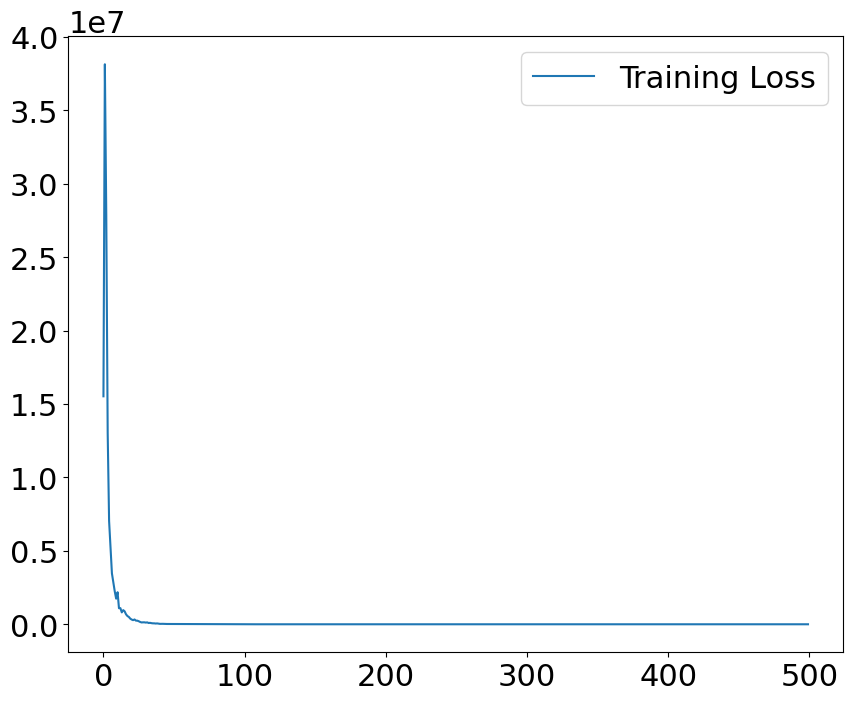

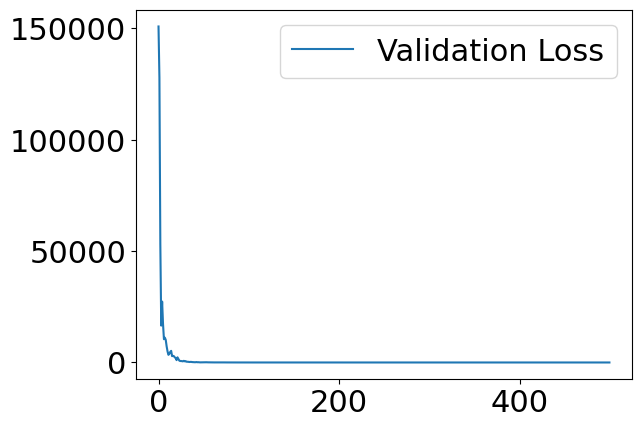

In [73]:
# visualize the loss as the network trained
# for for run in range(runs):
fig = plt.figure(figsize=(10,8))

train_loss_percent = [i / 100 for i in train_loss]
val_loss_percent = [i / 100 for i in val_loss]
# print(len(val_loss_percent))
# print(val_loss_percent)

plt.plot(train_loss_percent, label='Training Loss')
plt.legend()
plt.show()
plt.plot(val_loss_percent,label='Validation Loss')
plt.legend()
plt.show()

